# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агенство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020-2022 годы и получить некоторые выводы.

Необходимо выяснить, какие факторы влияют на зарплату специалиста Data Scientist, а также ответить на ключевые вопросы HR-агенства:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различный размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Дополнительные исследования:

* Есть ли взаимосвязь между размером зарплаты и объемом работы, выполняемой удаленно?  
* Есть ли взаимосвязь между размером зарплаты и типом трудоустройства?

Примем уровнем значимости равным 0.05 ($\alpha=0.05$).

Данные содержат следующие столбцы:
*   *work_year* — год, в котором была выплачена зарплата;
*   *experience_level* — опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN - Entry-level/Junior;
    * MI - Mid-level/Intermediate;
    * SE - Senior-level/Expert;
    * Executive-level/Director.
*   *employment_type* — тип трудоустройства для этой роли:
    * PT - неполный рабочий день;
    * FT - полный рабочий день;
    * CT - контракт;
    * FL - фриланс.
* *job_title* - роль, в которой соискатель работал в течение года;
* *salary* - общая выплаченная валовая сумма заработной платы;
* *salary_currency* - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
* *salary_in_usd* - зарплата в долларах США (валютный курс, деленный на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
* *employee_residence* - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
* *remote_ratio* - общий объем работы, выполняемой удаленно. Возможные значения:
    * 0 - удаленной работы нет (менее 20 %);
    * 50 - частично удаленная работа;
    * 100 - полностью удаленная работа (более 80 %).
* *company_location* - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
* *company_size* - среднее количество людей, работавших в компании в течение года:
    * S - менее 50 сотрудников (небольшая компания);
    * M - от 50 до 250 сотрудников (средняя компания);
    * L - более 250 сотрудников (крупная компания).

Оригинальный датасет: ["Data Science Job Salaries (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Данные были скопированы в Google Drive, они доступны по [Скачать данные](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip).

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Удалим первый столбец с порядковым номером записи

In [5]:
columns_to_frop = data.columns[0]
df = data.drop(columns_to_frop,axis=1)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


None

Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(df[df.duplicated()].shape[0]))

# Удаляем дубликаты:
df = df.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(df.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Удалим неинформативные признаки

Поскольку в датасете присутствует размер заработной платы сотрудника в долларах США, признаки salary и salary_currency не несут полезной информации. Удалим их.

In [7]:
df = df.drop(['salary', 'salary_currency'],axis=1)
display(df.head())

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


### Распределение заработной платы среди всех специалистов датасета

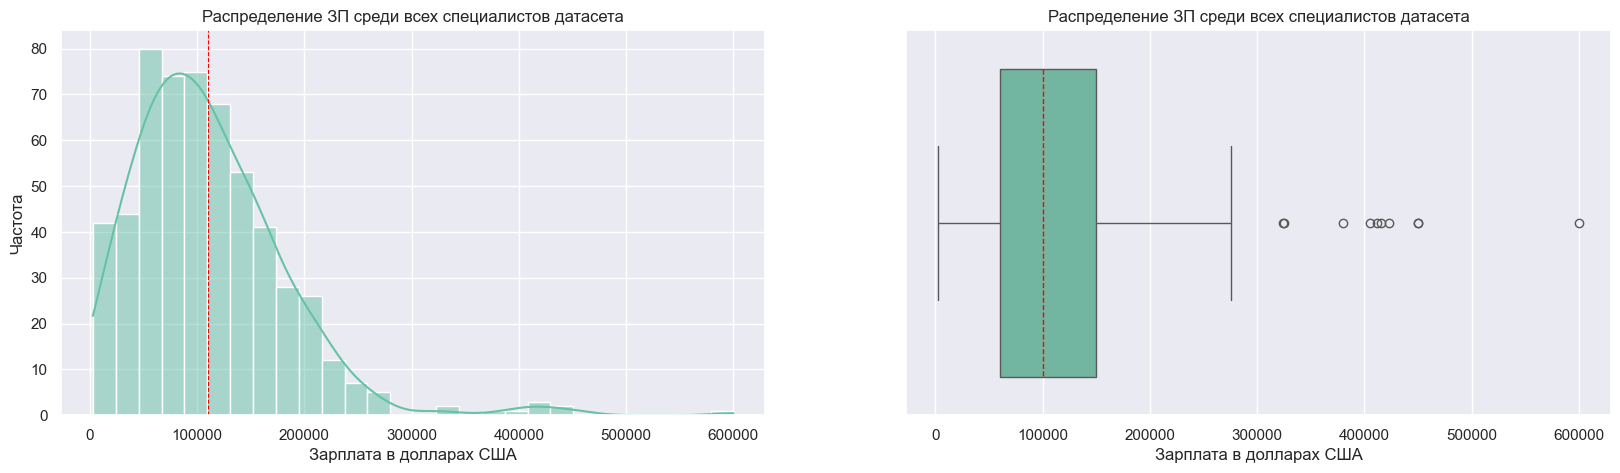

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Распределение ЗП среди всех специалистов датасета')
axes[0].axvline(df['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата в долларах США')
axes[1].set_title('Распределение ЗП среди всех специалистов датасета')

plt.show()

In [9]:
df_agg = df['salary_in_usd'].describe().round(2).to_frame()
df_agg.columns = ['Размер зарплаты']
display(df_agg)

,Размер зарплаты
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Распределение зарплат отлично от нормального, имеются выбросы.

### Зарплаты в зависимости от года выплат

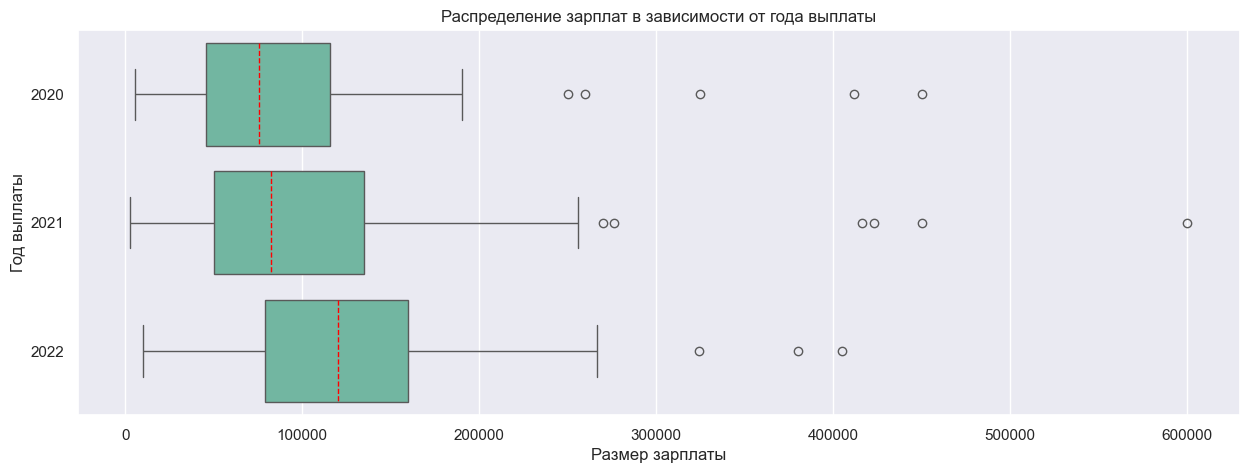

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.boxplot(df, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='Год выплаты')

plt.title('Распределение зарплат в зависимости от года выплаты')
plt.show()

In [11]:
df_agg = df.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Страховые выплаты в зависимости от пола')
display(df_agg)

Страховые выплаты в зависимости от пола


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


На первый взгляд, зарплаты специалистов Data Science с каждым годом растут. Чтобы убедиться в этом, в следующем разделе мы проведём статистическое тестирование.

### Соотношение зарплат Data Scientist и Data Engineer в 2022 году

Выделим специалистов Data Scientist и Data Engineer из общего датасета, введем признак 'ds_or_de', куда распределим данных специалистов независимо от их опыта и конкретной должности.

In [12]:
#l1 = list(df['job_title'].unique())
#display(l1)
# Выделим из выборки только Data Scientist и Data Engineer
df_ds_and_de = df[(df['job_title'].str.contains('Data Scientist', case=False) | df['job_title'].str.contains('Data Engineer', case=False))]
#display(df_ds_and_de['job_title'].unique())
df_ds_and_de['ds_or_de'] = df['job_title'].apply(lambda x: 'Data Scientist' if 'data scientist' in x.lower() else 'Data Engineer')

# Ограничим наблюдения 2022-м гдом
df_ds_and_de = df_ds_and_de[df_ds_and_de['work_year']==2022]

# Удалим исходный столбец
df_ds_and_de.drop('job_title', axis=1, inplace=True)
display(df_ds_and_de.groupby('ds_or_de')['ds_or_de'].count())

C:\Users\user\AppData\Local\Temp\ipykernel_11100\3258689792.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ds_and_de['ds_or_de'] = df['job_title'].apply(lambda x: 'Data Scientist' if 'data scientist' in x.lower() else 'Data Engineer')


ds_or_de
Data Engineer     80
Data Scientist    69
Name: ds_or_de, dtype: int64

Построим график распределения зарплат для данных специалистов.

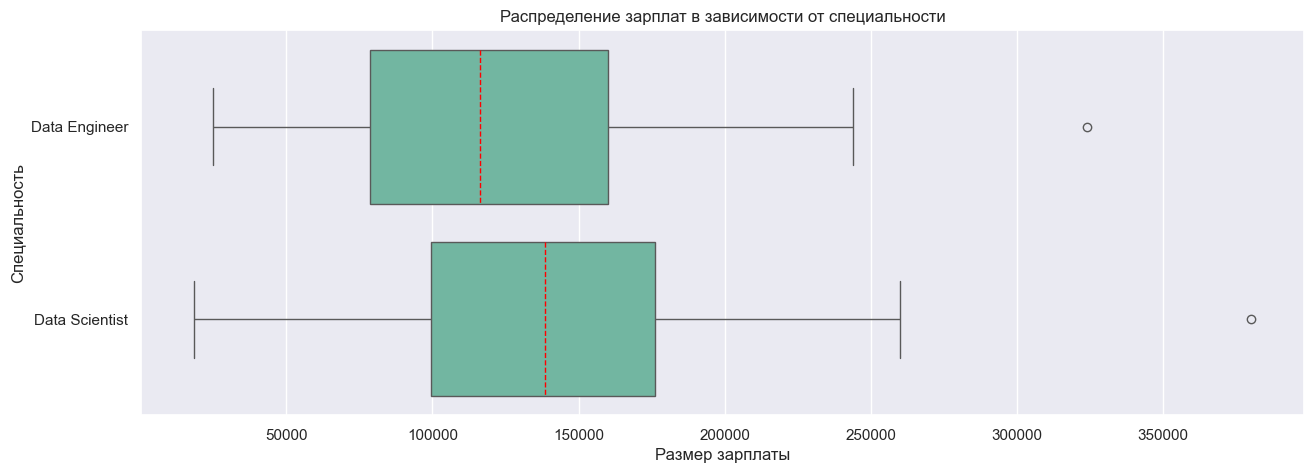

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.boxplot(df_ds_and_de, x='salary_in_usd', y='ds_or_de', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='Специальность')

plt.title('Распределение зарплат в зависимости от специальности')
plt.show()

In [14]:
df_ds_and_de_agg = df_ds_and_de.groupby('ds_or_de')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от специальности')
df_ds_and_de_agg

Зарплаты в зависимости от специальности


,count,mean,std,min,25%,50%,75%,max
ds_or_de,,,,,,,,
Data Engineer,80.0,124570.98,57484.1,25000.0,78526.0,116394.5,160020.0,324000.0
Data Scientist,69.0,136456.88,62180.7,18442.0,99360.0,138600.0,176000.0,380000.0


Зарплаты Data Scientist незначительно превышали зарплаты Data Engineer в 2022 году. Чтобы проверить это, в следующем разделе мы проведём статистические тесты.

### Соотношение зарплат специалистов Data Scientist в компаниях различных размеров

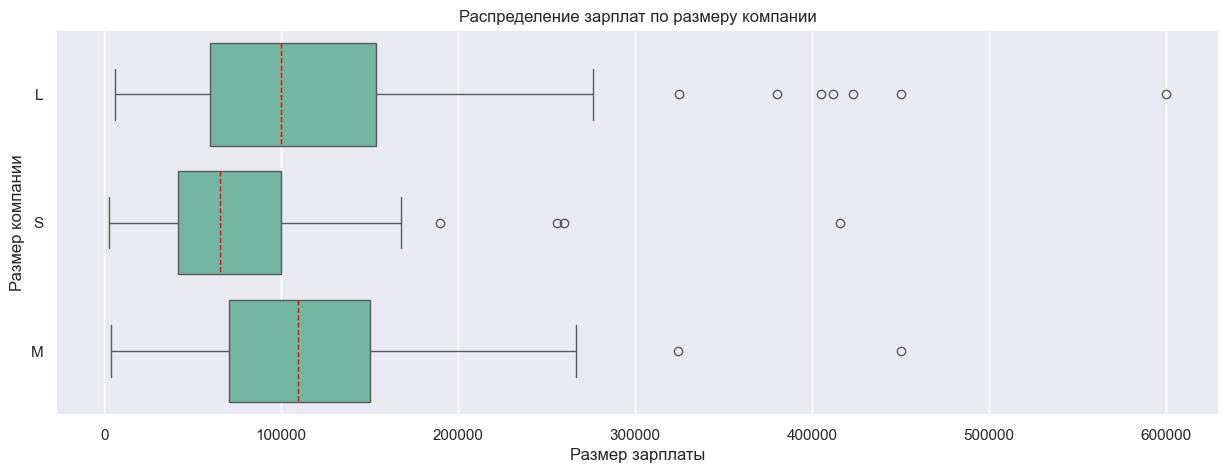

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.boxplot(df, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='Размер компании')
plt.title('Распределение зарплат по размеру компании')
plt.show()

In [16]:
df_agg = df.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от размера компании')
df_agg

Зарплаты в зависимости от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0
M,290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0
S,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0


Распределения зарплат в компаниях различных размеров отличаются (чем больше компания, тем больше зарплата). Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании

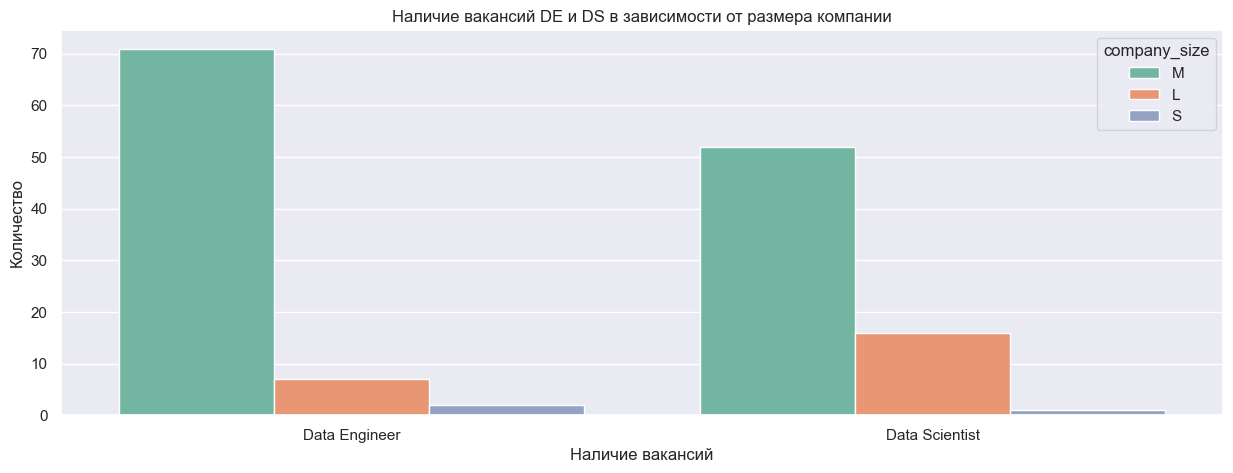

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.countplot(data=df_ds_and_de, x=df_ds_and_de['ds_or_de'], hue='company_size')
ax.set(xlabel='Наличие вакансий', ylabel='Количество')
plt.title('Наличие вакансий DE и DS в зависимости от размера компании')
plt.show()

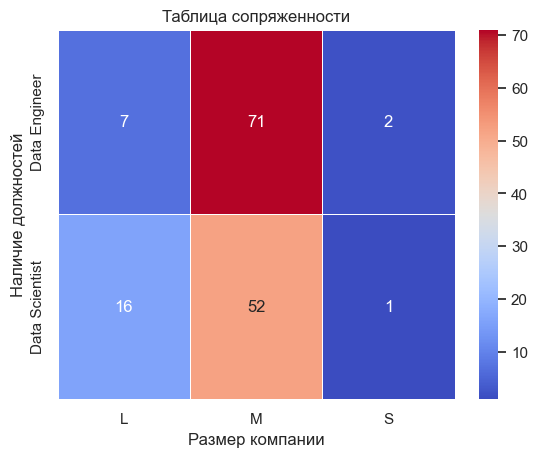

In [18]:
cross_tab = pd.crosstab(index=df_ds_and_de['ds_or_de'], columns=df_ds_and_de['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Наличие должностей')
plt.title('Таблица сопряженности')
plt.show()

По графикам видно, что размер компании влияет на наличие должностей Data Scientist и Data Engineer. Чтобы проверить это, в следующем разделе мы проведём статистические тесты.

Связь между размером зарплаты и объемом работы, выполняемой удаленно

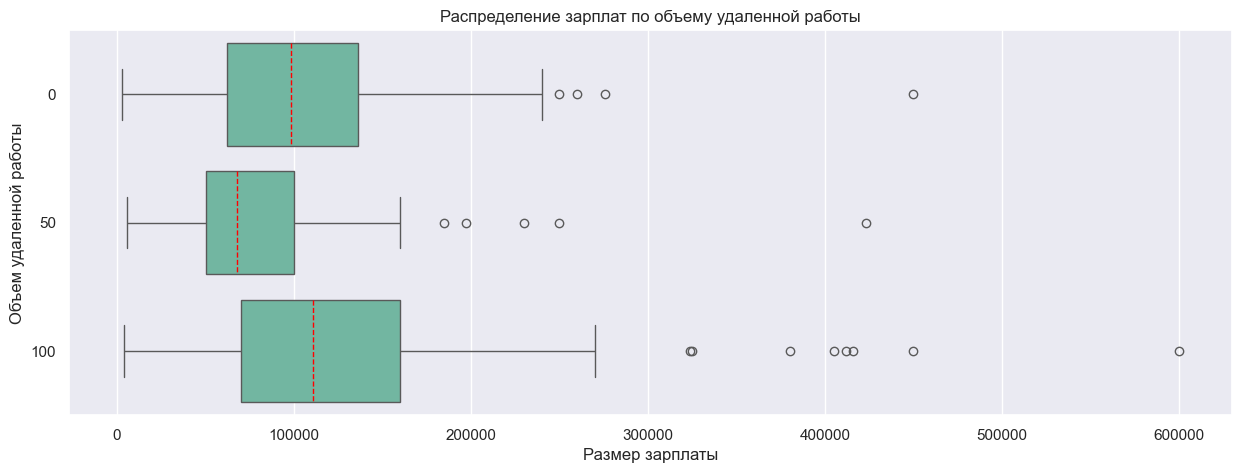

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.boxplot(df, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='Объем удаленной работы')
plt.title('Распределение зарплат по объему удаленной работы')
plt.show()

In [20]:
df_agg = df.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от объема удаленной работы')
df_agg

Зарплаты в зависимости от объема удаленной работы


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,121.0,105785.40,68392.50,2859.0,62000.0,98158.0,136000.00,450000.0
50,98.0,80721.90,57639.10,5409.0,50000.5,68010.5,99925.75,423000.0
100,346.0,120763.19,74930.43,4000.0,70000.0,110712.5,159750.00,600000.0


Распределения зарплат в зависимости от объема удаленной работы различаются (для полностью удаленной работы разброс ЗП наибольший, также как и максимальный размер ЗП). Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

Cвязь между размером зарплаты и типом трудоустройства

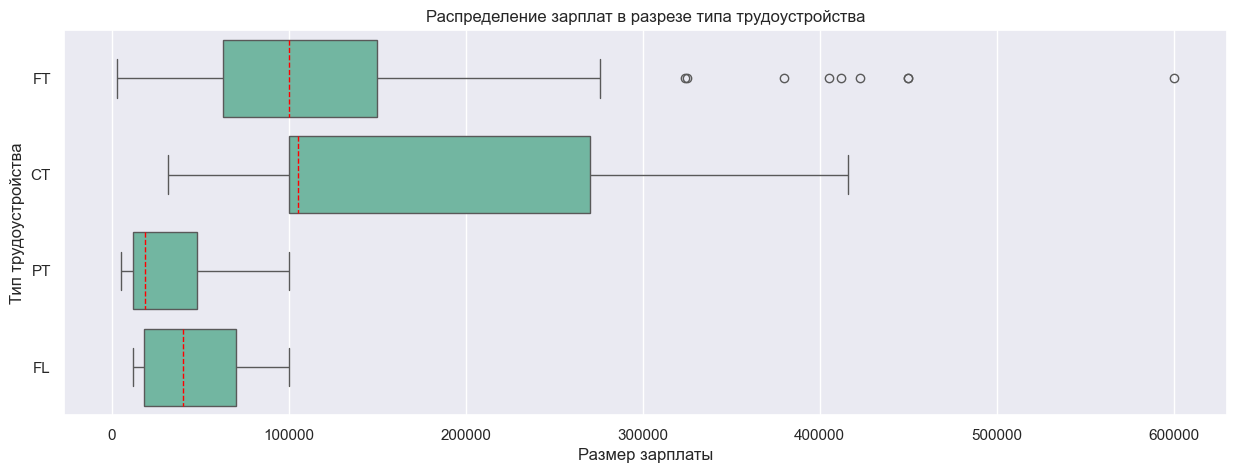

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.boxplot(df, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='Тип трудоустройства')
plt.title('Распределение зарплат в разрезе типа трудоустройства')
plt.show()

In [22]:
df_agg = df.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от типа трудоустройства')
df_agg

Зарплаты в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.0,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.0,40000.0,70000.0,100000.0
FT,546.0,111811.84,70790.70,2859.0,62726.0,100000.0,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.0,18817.5,48370.0,100000.0


Распределения зарплат в зависимости от типа трудоустройства значительно различаются (для контрактной работы ожидаемо самый большой разброс ЗП и наибольший размер ЗП). Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [23]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist не отличается в разные годы: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплат у специалистов Data Scientist отличается в разные годы: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [24]:
# значения зарплат по годам
salary_2020 = df.loc[data['work_year']==2020, 'salary_in_usd']
salary_2021 = df.loc[data['work_year']==2021, 'salary_in_usd']
salary_2022 = df.loc[data['work_year']==2022, 'salary_in_usd']

#display(salary_2020)

# проводим тест Шапиро-Уилка
print('Для 2020 года:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах).

**Проведём тест**

In [25]:
# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Тест подтверждает изменения зарплат специалистов Data Science с течением времени.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат Data Scientist ($μ_1$) статистически меньше либо равен размеру зарплат Data Engineer ($μ_2$).

$$ H_0 : μ_1 \leq μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат Data Scientist ($μ_1$) статистически больше размера зарплат Data Engineer ($μ_2$).
$$ H_1 : μ_1 > μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [26]:
# значения зарплат DS и DE
salary_ds = df_ds_and_de.loc[df_ds_and_de['ds_or_de']=='Data Scientist', 'salary_in_usd']
salary_de = df_ds_and_de.loc[df_ds_and_de['ds_or_de']=='Data Engineer', 'salary_in_usd']

#display(salary_ds.count())
#display(salary_de.count())

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(salary_ds)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(salary_de)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [27]:
# проводим тест
_, p = stats.mannwhitneyu(salary_ds, salary_de, alternative='greater')
decision_hypothesis(p)

p-value = 0.084
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Статистический тест показал, что у нас нет оснований отвергнуть нулевую гипотезу. Зарплаты Data Scientist не превышают зарплаты Data Engineer в 2022 году.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплат специалистов Data Scientist не отличается в компаниях разных размеров: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплат специалистов Data Scientist отличается в компаниях разных размеров: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [28]:
# значения зарплат в разных компаниях
df_company_s = df.loc[data['company_size']=='S', 'salary_in_usd']
df_company_m = df.loc[data['company_size']=='M', 'salary_in_usd']
df_company_l = df.loc[data['company_size']=='L', 'salary_in_usd']

#display(df_company_s.count(), df_company_m.count(), df_company_l.count())

# проводим тест Шапиро-Уилка
print('Для маленьких (S) компаний:')
result = stats.shapiro(df_company_s)
decision_normality(result[1])

print('Для средних (M) компаний:')
result = stats.shapiro(df_company_m)
decision_normality(result[1])

print('Для больших (L) компаний:')
result = stats.shapiro(df_company_l)
decision_normality(result[1])


Для маленьких (S) компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для средних (M) компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для больших (L) компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [29]:
# проводим тест
_, p = stats.kruskal(df_company_s, df_company_m, df_company_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Статистический тест показал, что размер компании влияет на зарплату специалистов Data Science.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между размером компании и наличием должностей Data Scientist и Data Engineer нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между размером компании и наличием должностей Data Scientist и Data Engineer есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Пол»? — Категориальный.
* Сколько сравниваемых групп? — Три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [30]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(index=df_ds_and_de['ds_or_de'], columns=df_ds_and_de['company_size'])

display(cross_table)

company_size,L,M,S
ds_or_de,,,
Data Engineer,7,71,2
Data Scientist,16,52,1


In [31]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.050
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь наличием должностей Data Scientist и Data Engineer и размером компании.

### Есть ли взаимосвязь между размером зарплаты и объемом работы, выполняемой удаленно?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплат специалистов Data Scientist не отличается в зависимости от объема работы, выполняемой удаленно: нет удаленной работы ($μ_1$), частично удаленная работа ($μ_2$), полностью удаленная работа ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплат специалистов Data Scientist отличается в зависимости от объема работы, выполняемой удаленно: нет удаленной работы ($μ_1$), частично удаленная работа ($μ_2$), полностью удаленная работа ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [32]:
# значения зарплат в зависимости от объема удаленной работы
salary_remote_ratio_0 = df.loc[data['remote_ratio']==0, 'salary_in_usd']
salary_remote_ratio_50 = df.loc[data['remote_ratio']==50, 'salary_in_usd']
salary_remote_ratio_100 = df.loc[data['remote_ratio']==100, 'salary_in_usd']

#display(salary_remote_ratio_0)

# проводим тест Шапиро-Уилка
print('Без удаленной работы:')
result = stats.shapiro(salary_remote_ratio_0)
decision_normality(result[1])

print('Для частично удаленной:')
result = stats.shapiro(salary_remote_ratio_50)
decision_normality(result[1])

print('Для полностью удаленной:')
result = stats.shapiro(salary_remote_ratio_100)
decision_normality(result[1])

Без удаленной работы:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для частично удаленной:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для полностью удаленной:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [33]:
# проводим тест
_, p = stats.kruskal(salary_remote_ratio_0, salary_remote_ratio_50, salary_remote_ratio_100)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Статистический тест показал, что объем работы, выполняемой удаленно, влияет на зарплату специалистов Data Science.

### Есть ли взаимосвязь между размером зарплаты и типом трудоустройства?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплат специалистов Data Scientist не отличается в зависимости от типа трудоустройства: неполный рабочий день ($μ_1$), полный рабочий день ($μ_2$), контракт ($μ_3$)б фриланс ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер зарплат специалистов Data Scientist отличается в зависимости от типа трудоустройства: неполный рабочий день ($μ_1$), полный рабочий день ($μ_2$), контракт ($μ_3$)б фриланс ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [34]:
# значения зарплат в зависимости от типа трудоустройства
salary_employment_type_pt = df.loc[data['employment_type']=='PT', 'salary_in_usd']
salary_employment_type_ft = df.loc[data['employment_type']=='FT', 'salary_in_usd']
salary_employment_type_ct = df.loc[data['employment_type']=='CT', 'salary_in_usd']
salary_employment_type_fl = df.loc[data['employment_type']=='FL', 'salary_in_usd']

#display(salary_employment_type_pt)

# проводим тест Шапиро-Уилка
print('Неполный рабочий день:')
result = stats.shapiro(salary_employment_type_pt)
decision_normality(result[1])

print('Полный рабочий день::')
result = stats.shapiro(salary_employment_type_ft)
decision_normality(result[1])

print('Контракт:')
result = stats.shapiro(salary_employment_type_ct)
decision_normality(result[1])

print('Фриланс:')
result = stats.shapiro(salary_employment_type_fl)
decision_normality(result[1])

Неполный рабочий день:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Полный рабочий день::
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Контракт:
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Фриланс:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (для типов трудоустройства "контракт" и "фриланс" тест показал нормальное распределение, возможно, это связано с малым размером выборки для данных случаев). 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [35]:
# проводим тест
_, p = stats.kruskal(salary_employment_type_pt, salary_employment_type_ft, salary_employment_type_ct, salary_employment_type_fl)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Статистический тест показал, что тип трудоустройства влияет на зарплату специалистов Data Science.

## Итоговые результаты исследования

Статистические тесты, в основном, подтвердили предварительные выводы, сделанные из визуальной оценки признаков.

* Есть ежегодный рост зарплат у специалистов Data Scientist.
* Зарплаты Data Scientist не превышали зарплаты Data Engineer в 2022 году (на графике было заметно небольшое превышение, но тест показал, что оно не имеет статистической значимости).
* Распределения зарплат в компаниях различных размеров отличаются (чем больше компания, тем больше зарплата). Это было подтверждено статистическими тестами.
* Тесты показали, что размер компании влияет на наличие должностей Data Scientist и Data Engineer.

Дополнительные исследования:

* Взаимосвязь между размером зарплаты и объемом работы, выполняемой удаленно, существует. Это было подтверждено статистическими тестами.
* Взаимосвязь между размером зарплаты и типом трудоустройства также существует. Это было подтверждено статистическими тестами. Возможно, основной вклад в различия вносят "контракт" и фриланс". Можно провести отдельные исследования, получив большую выборку специалистов с данным типом трудоустройства. 